## Loading the CIFAR10 data set

In [0]:
import keras
from keras.datasets import cifar10
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras import Model
from keras.utils.vis_utils import model_to_dot
import numpy as np
import os
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt

# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplan', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Model parameters

In [0]:
# Training parameters
batch_size = 64
epochs = 20
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
n = 3

# Model version
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [102]:
print(model_type)

ResNet20v1


## Preprocess the data

In [103]:
# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Input dimensions
input_shape = x_train.shape[1:]

# Number of non-test examples
num_non_test = x_train.shape[0] 

# shuffle non-test data
shuffled_indices = np.random.permutation(num_non_test)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Simple hold-out validation 
# Note that this could be also achieved by setting validation_split to 0.2

# Number of training examples
num_train = int(0.8 * num_non_test)

# Split into validation and train data
x_val = x_train[num_train:]
y_val = y_train[num_train:]

x_train = x_train[:num_train]
y_train = y_train[:num_train]

print('shapes')
print()
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val  :', x_val.shape)
print('y_val  :', y_val.shape)
print('x_test :', x_test.shape)
print('y_test :', y_test.shape)

shapes

x_train: (40000, 32, 32, 3)
y_train: (40000, 10)
x_val  : (10000, 32, 32, 3)
y_val  : (10000, 10)
x_test : (10000, 32, 32, 3)
y_test : (10000, 10)


## Model 1 - Underfitting

In [0]:
# set up the layers
model1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((20, 20)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
# compile the model
model1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [106]:
# train the model
epochs = 20
history = model1.fit(x_train, y_train,
                        batch_size=64,
                        epochs=epochs,
                        validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 5s 136us/step - loss: 1.9356 - acc: 0.2891 - val_loss: 1.7184 - val_acc: 0.3787
Epoch 2/20
40000/40000 [==============================] - 4s 101us/step - loss: 1.6325 - acc: 0.4137 - val_loss: 1.5989 - val_acc: 0.4329
Epoch 3/20
40000/40000 [==============================] - 4s 101us/step - loss: 1.5292 - acc: 0.4531 - val_loss: 1.5084 - val_acc: 0.4664
Epoch 4/20
40000/40000 [==============================] - 4s 102us/step - loss: 1.4694 - acc: 0.4789 - val_loss: 1.4609 - val_acc: 0.4926
Epoch 5/20
40000/40000 [==============================] - 4s 101us/step - loss: 1.4271 - acc: 0.4934 - val_loss: 1.4300 - val_acc: 0.4992
Epoch 6/20
40000/40000 [==============================] - 4s 102us/step - loss: 1.3945 - acc: 0.5038 - val_loss: 1.4344 - val_acc: 0.4946
Epoch 7/20
40000/40000 [==============================] - 4s 102us/step - loss: 1.3683 - acc: 0.5139 - val_loss: 1.4105 - 

In [107]:
# Evaluate accuracy
test_loss1, test_acc1 = model1.evaluate(x_test, y_test)

print('Test accuracy:', test_acc1)

10000/10000 [==============================] - 1s 68us/step
Test accuracy: 0.5415


In [0]:
# Training/test loss/accuracy during training
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs+1)

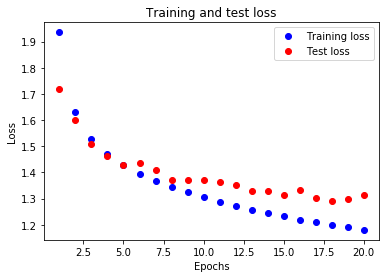

In [109]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

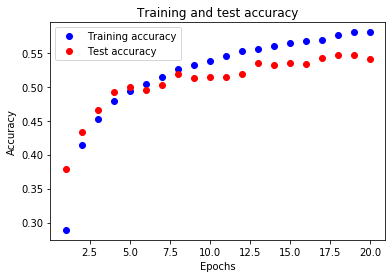

In [111]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 2 - Overfitting

In [0]:
# set up the layers
model2 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
# compile the model
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [35]:
# train the model
epochs = 20
history = model2.fit(x_train, y_train,
                        batch_size=64,
                        epochs=epochs,
                        validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/20





40000/40000 [==============================] - 12s 291us/step - loss: 1.4534 - acc: 0.4848 - val_loss: 1.2301 - val_acc: 0.5682
Epoch 2/20
40000/40000 [==============================] - 4s 98us/step - loss: 1.0464 - acc: 0.6354 - val_loss: 1.0594 - val_acc: 0.6317
Epoch 3/20
40000/40000 [==============================] - 4s 98us/step - loss: 0.8800 - acc: 0.6949 - val_loss: 0.9833 - val_acc: 0.6580
Epoch 4/20
40000/40000 [==============================] - 4s 99us/step - loss: 0.7585 - acc: 0.7358 - val_loss: 0.9759 - val_acc: 0.6721
Epoch 5/20
40000/40000 [==============================] - 4s 98us/step - loss: 0.6539 - acc: 0.7716 - val_loss: 1.0492 - val_acc: 0.6587
Epoch 6/20
40000/40000 [==============================] - 4s 98us/step - loss: 0.5543 - acc: 0.8078 - val_loss: 1.0610 - val_acc: 0.6617
Epoch 7/20
40000/40000 [

In [37]:
# Evaluate accuracy
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

print('Test accuracy:', test_acc2)

10000/10000 [==============================] - 1s 63us/step
Test accuracy: 0.6367


In [0]:
# Training/test loss/accuracy during training
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs+1)

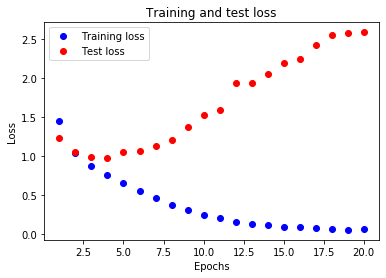

In [39]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

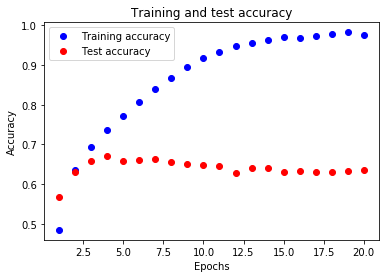

In [41]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 3 - Pretty Good

In [0]:
# set up the layers
model3 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
# compile the model
model3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [93]:
# train the model
epochs = 10
history = model3.fit(x_train, y_train,
                        batch_size=64,
                        epochs=epochs,
                        validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 164us/step - loss: 1.6545 - acc: 0.3947 - val_loss: 1.3548 - val_acc: 0.5123
Epoch 2/10
40000/40000 [==============================] - 5s 127us/step - loss: 1.2226 - acc: 0.5608 - val_loss: 1.0322 - val_acc: 0.6341
Epoch 3/10
40000/40000 [==============================] - 5s 129us/step - loss: 1.0093 - acc: 0.6431 - val_loss: 0.8795 - val_acc: 0.6926
Epoch 4/10
40000/40000 [==============================] - 5s 128us/step - loss: 0.8802 - acc: 0.6899 - val_loss: 0.8769 - val_acc: 0.6962
Epoch 5/10
40000/40000 [==============================] - 5s 129us/step - loss: 0.7952 - acc: 0.7218 - val_loss: 0.7541 - val_acc: 0.7352
Epoch 6/10
40000/40000 [==============================] - 5s 128us/step - loss: 0.7234 - acc: 0.7452 - val_loss: 0.7725 - val_acc: 0.7292
Epoch 7/10
40000/40000 [==============================] - 5s 127us/step - loss: 0.6724 - acc: 0.7614 - val_loss: 0.7635 - 

In [94]:
# Evaluate accuracy
test_loss3, test_acc3 = model3.evaluate(x_test, y_test)

print('Test accuracy:', test_acc3)

10000/10000 [==============================] - 1s 76us/step
Test accuracy: 0.7566


In [0]:
# Training/test loss/accuracy during training
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs+1)

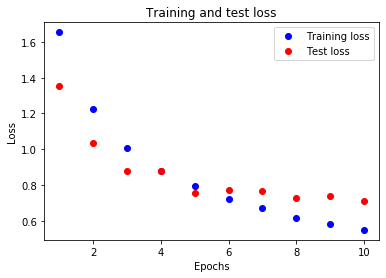

In [96]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

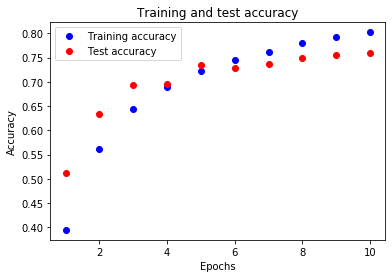

In [98]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()